# Pytorch Implementation of EEGLearn - P. Bashivan

This notebook describes a short summary of Pytorch implementation of the models described in "Learning Representations from EEG with Deep Recurrent-Convolutional Neural Networks." Bashivan et al. at International conference on learning representations (2016).

The rest of the code is in the different python scripts of this repo.

All the codes have been inspired from the [original github](https://github.com/pbashivan/EEGLearn).

## Librairies Import

In [1]:
import numpy as np 
import scipy.io as sio
from scipy import signal
import torch
import os 
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader,random_split
from matplotlib import pyplot as plt

from Utils import *
from Models import *

torch.manual_seed(1234)
np.random.seed(1234)

import warnings
warnings.simplefilter("ignore")

## Loading the original Images 
The images have directly been taken from original implementation, given that they remain the same nevermind the implementation (Pytorch, Tensorflow, Theano).

In [2]:
Mean_Images = sio.loadmat("Sample Data/images.mat")["img"] #corresponding to the images mean for all the seven windows
print(np.shape(Mean_Images)) 
Images = sio.loadmat("Sample Data/images_time.mat")["img"] #corresponding to the images mean for all the seven windows
print(np.shape(Images)) 
Label = (sio.loadmat("Sample Data/FeatureMat_timeWin")["features"][:,-1]-1).astype(int) #corresponding to the signal label (i.e. load levels).
print(np.shape(Label)) 
Patient_id = sio.loadmat("Sample Data/trials_subNums.mat")['subjectNum'][0] #corresponding to the patient id
print(np.shape(Patient_id))

(2670, 3, 32, 32)
(7, 2670, 3, 32, 32)
(2670,)
(2670,)


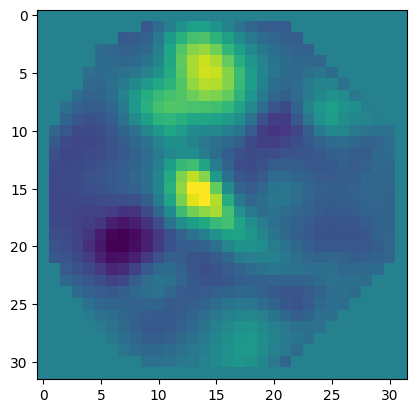

In [3]:
# write code to plot matrix of dimension 3,32,32 as a color image
plt.imshow(Mean_Images[0,0, :,:])

## Loading patient dataset 
From the total data, we select the images corresponding patient. 

In [4]:
print("Choose among the patient : "+str(np.unique(Patient_id)))

Choose among the patient : [ 1  2  3  4  6  7  8  9 10 11 12 14 15]


In [5]:
chosen_patient = 1
# load file from folder kamyar_data
files = sio.loadmat("kamyar_data/TrainData1.mat")['TrainData1']
Mean_Images = files[:,:]
Label = files[:,9]


In [6]:
 # **************************** Data Segmentation *********************
def DataSegmentation(data, t1, t2):
    Data_Frame = pd.DataFrame()
    df = pd.DataFrame(data)
    dt = df.loc[0][1] - df.loc[0][0]
    fs = 1/dt
    sample_num = np.floor((t1+t2)*fs)
    epoch_loc = np.where(np.diff(np.sign(df.loc[9])) == 1)[0] + 1
    for j in range(1,9):
        signals = []
        for i in range(epoch_loc.shape[0]):
            temp = df.loc[j][epoch_loc[i]-np.int64(t1*fs) : epoch_loc[i]+np.int64(t2*fs)+1].values
            # temp = temp/np.max(abs(temp))
            signals.append(temp)
        Data_Frame['Ch' + str(j)] = signals
    Data_Frame['ChannelMean'] = [[0] for i in range(Data_Frame.shape[0])]
    for i in range(Data_Frame.shape[0]):
        Data_Frame['ChannelMean'][i] = np.mean(Data_Frame.loc[i][:-1])

    try:
        target_loc = np.where(df.loc[10] == 1)[0]
        labels = np.zeros(epoch_loc.shape)
        for i in range(target_loc.shape[0]):
            temp = np.where(epoch_loc == target_loc[i])[0]
            if temp.shape[0] == 0:
                continue
            labels[temp[0]] = 1
        Data_Frame['labels'] = labels
        return (Data_Frame, fs, pd.DataFrame(data).loc[9][epoch_loc].values)
    except:
        return (Data_Frame, fs, pd.DataFrame(data).loc[9][epoch_loc].values)



In [7]:
# each row of mean_images represents a signal in time domain, take the wavelet transform of each row
cwts,_,_ = DataSegmentation(Mean_Images, 100/1000, 400/1000)

In [8]:
signals = cwts.iloc[:,:-2].values
signals = signals.flatten()
signals = np.array([np.array(signals[i]) for i in range(signals.shape[0])])
print (signals.shape)
labels = cwts.iloc[:,-1].values

(21600, 128)


In [9]:
# convert each row of signals to wavelet transform matrix
wavelets = np.zeros((signals.shape[0], 128, 128))
for i in range(signals.shape[0]):
    wavelets[i,:,:] = signal.cwt(signals[i,:], signal.ricker, np.arange(1, 129))

In [10]:
wavelets = wavelets.reshape((wavelets.shape[0], 1, wavelets.shape[1], wavelets.shape[2]))
wavelets = wavelets.reshape((int(wavelets.shape[0] / 8), 8, wavelets.shape[2], wavelets.shape[3]))
print (wavelets.shape)
print (labels.shape)

(2700, 8, 128, 128)
(2700,)


## Introduction: BasicCNN
First Implementation of a CNN on the Mean Images from each patient

In [11]:
train_part = 0.8
test_part = 0.2

batch_size = 32

In [12]:
print (wavelets.shape)
print (labels.shape)

(2700, 8, 128, 128)
(2700,)


In [13]:
# cast labels to long int
labels = labels.astype(np.int64)

In [14]:
# split data into two parts based on labels being 0 or 1
wavelets_0 = wavelets[labels == 0]
print (wavelets_0.shape)
wavelets_1 = wavelets[labels == 1]
# shuffle both and corresponding elements of labels
inds = np.arange(wavelets_0.shape[0])
np.random.shuffle(inds)

wavelets_0 = wavelets_0[inds]
labels_0 = labels[labels == 0][inds]
wavelets_0 = wavelets_0[:75, :, :, :]
labels_0 = labels_0[:75]

wavelets_1 = wavelets_1[:,:,:,:]
labels_1 = labels[labels == 1]

# take train_part of each
wavelets_0_train = wavelets_0[:int(wavelets_0.shape[0] * train_part)]
labels_0_train = labels_0[:int(labels_0.shape[0] * train_part)]
wavelets_1_train = wavelets_1[:int(wavelets_1.shape[0] * train_part)]
labels_1_train = labels_1[:int(labels_1.shape[0] * train_part)]
# take test_part of each
wavelets_0_test = wavelets_0[int(wavelets_0.shape[0] * train_part):]
labels_0_test = labels_0[int(labels_0.shape[0] * train_part):]
wavelets_1_test = wavelets_1[int(wavelets_1.shape[0] * train_part):]
labels_1_test = labels_1[int(labels_1.shape[0] * train_part):]
# concatenate wavelets_0_train and wavelets_1_train
wavelets_train = np.concatenate((wavelets_0_train, wavelets_1_train), axis=0)
labels_train = np.concatenate((labels_0_train, labels_1_train), axis=0)
# concatenate wavelets_0_test and wavelets_1_test
wavelets_test = np.concatenate((wavelets_0_test, wavelets_1_test), axis=0)
labels_test = np.concatenate((labels_0_test, labels_1_test), axis=0)

(2625, 8, 128, 128)


In [15]:
EEG = EEGImagesDataset(label=labels, image=wavelets)

lengths = [int(len(EEG)*train_part), int(len(EEG)*test_part)]
Train, Test = random_split(EEG, lengths)

Trainloader = DataLoader(Train,batch_size=batch_size)
Testloader = DataLoader(Test, batch_size=batch_size)

In [23]:
res = TrainTest_Model(BasicCNN, Trainloader, Testloader, n_epoch=15, learning_rate=0.001, print_epoch=-1, opti='Adam')

[1,  15]	loss: 0.692	Accuracy : 0.936		val-loss: 0.510	val-Accuracy : 0.967
[2,  15]	loss: 0.471	Accuracy : 0.974		val-loss: 0.510	val-Accuracy : 0.967
[3,  15]	loss: 0.470	Accuracy : 0.974		val-loss: 0.508	val-Accuracy : 0.967
[4,  15]	loss: 0.465	Accuracy : 0.974		val-loss: 0.509	val-Accuracy : 0.967
[5,  15]	loss: 0.470	Accuracy : 0.974		val-loss: 0.505	val-Accuracy : 0.967
[6,  15]	loss: 0.464	Accuracy : 0.974		val-loss: 0.506	val-Accuracy : 0.967
[7,  15]	loss: 0.515	Accuracy : 0.974		val-loss: 0.509	val-Accuracy : 0.967
[8,  15]	loss: 0.467	Accuracy : 0.974		val-loss: 0.509	val-Accuracy : 0.967
[9,  15]	loss: 0.463	Accuracy : 0.974		val-loss: 0.510	val-Accuracy : 0.967
[10,  15]	loss: 0.466	Accuracy : 0.974		val-loss: 0.513	val-Accuracy : 0.967
[11,  15]	loss: 0.462	Accuracy : 0.974		val-loss: 0.512	val-Accuracy : 0.967
[12,  15]	loss: 0.464	Accuracy : 0.974		val-loss: 0.509	val-Accuracy : 0.967
[13,  15]	loss: 0.460	Accuracy : 0.974		val-loss: 0.507	val-Accuracy : 0.967
[14,  15

In [17]:
# print accuracy of the model
print (res)

(0.6858674953558982, 0.8851851851851852, 0.5330066786092871, 0.9685185185185186, [tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), tensor

## Maxpool CNN
Build the Max-pooling model performing a maxpool over the 7 parallel convnets.

In [18]:
train_part = 0.8
test_part = 0.2

batch_size = 32

In [19]:
EEG = EEGImagesDataset(label=labels, image=wavelets)

lengths = [int(len(EEG)*train_part), int(len(EEG)*test_part)]
Train, Test = random_split(EEG, lengths)

Trainloader = DataLoader(Train,batch_size=batch_size)
Testloader = DataLoader(Test, batch_size=batch_size)

In [20]:
res = TrainTest_Model(MaxCNN, Trainloader, Testloader, n_epoch=1, learning_rate=0.001, print_epoch=5, opti='Adam')

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 32, 128, 128] to have 3 channels, but got 32 channels instead

## Temp CNN
FBuild the Conv1D model performing a convolution1D over the 7 parallel convnets.

In [ ]:
print('Begin Training for Patient '+str(choosen_patient))
res = TrainTest_Model(TempCNN, Trainloader, Testloader, n_epoch=45, learning_rate=0.001, print_epoch=5, opti='Adam')

## LSTM CNN
Build the LSTM model applying a RNN over the 7 parallel convnets outputs

In [ ]:
EEG = EEGImagesDataset(label=Label[Patient_id==choosen_patient], image=Images[Patient_id==choosen_patient])

lengths = [int(len(EEG)*train_part+1), int(len(EEG)*test_part)]
Train, Test = random_split(EEG, lengths)

Trainloader = DataLoader(Train,batch_size=batch_size)
Testloader = DataLoader(Test, batch_size=batch_size)

In [ ]:
print('Begin Training for Patient '+str(choosen_patient))
res = TrainTest_Model(LSTM, Trainloader, Testloader, n_epoch=45, learning_rate=0.0001, print_epoch=5, opti='Adam')

## Mix CNN
Build the LSTM model applying a RNN and a CNN over the 7 parallel convnets outputs

In [ ]:
EEG = EEGImagesDataset(label=Label[Patient_id==choosen_patient], image=Images[Patient_id==choosen_patient])

lengths = [int(len(EEG)*train_part+1), int(len(EEG)*test_part)]
Train, Test = random_split(EEG, lengths)

Trainloader = DataLoader(Train,batch_size=batch_size)
Testloader = DataLoader(Test, batch_size=batch_size)

In [ ]:
print('Begin Training for Patient '+str(choosen_patient))
res = TrainTest_Model(Mix, Trainloader, Testloader, n_epoch=60, learning_rate=0.00001, print_epoch=5, opti='Adam')